####Copyright https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans

In [ ]:
#Import libraries
import torch 
import torchvision
from torchvision.datasets import MNIST

In [ ]:
#Import training dataset
dataset = MNIST(root='data/', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(dataset)

60000

In [ ]:
#import the test dataset
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F39D9772850>, 5)

In [ ]:
#import libraries to plot the images
import matplotlib.pyplot as plt
#%matplotlib inline

label:  5


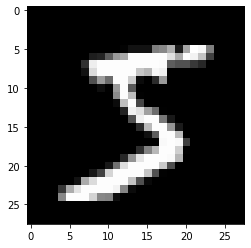

In [ ]:

#Show some test images
img, label = dataset[0]
plt.imshow(img, cmap='gray')
print('label: ', label)

label:  3


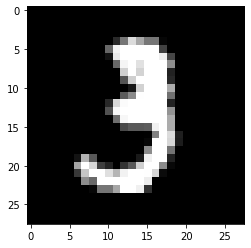

In [ ]:
#See some more example
img, label = dataset[10]
plt.imshow(img, cmap='gray')
print('label: ', label)

In [ ]:
#Converting the images into tensors as Pytorch only accepts the tensors
import torchvision.transforms as transforms

In [ ]:
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [ ]:
image_tensor, label = dataset[0]
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [ ]:
#Split the data into training and validation
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [50000,10000])
len(train_ds) , len(val_ds)

(50000, 10000)

In [ ]:
#Converting datasets into batches using DataLoader library
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [ ]:
import torch.nn as nn
input_size = 28 * 28
num_classes = 10
model = nn.Linear(input_size, num_classes)

In [ ]:
print(model.weight.shape)
model.bias.shape

torch.Size([10, 784])


torch.Size([10])

In [ ]:
#Flattering the dataset


In [ ]:
for images, labels in train_loader:
  print(labels.shape)
  images = images.reshape(batch_size, 784)
  print(images.shape)
  output = model(images)
  break


torch.Size([128])
torch.Size([128, 784])


In [ ]:
class MinistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear= nn.Linear(input_size, num_classes)
  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out
model = MinistModel()

In [ ]:

model.linear

Linear(in_features=784, out_features=10, bias=True)

In [ ]:
model.forward

<bound method MinistModel.forward of MinistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)>

In [ ]:
print(model.linear.weight.shape, model.linear.bias.shape)
#list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


In [ ]:

for images, labels in train_loader:
  outputs = model(images)
  break
print("outputs.shape: ", outputs.shape)
print('sample outputs:\n', outputs[:2].data)

outputs.shape:  torch.Size([128, 10])
sample outputs:
 tensor([[-0.6346,  0.0084, -0.0935,  0.0607,  0.2426, -0.1526, -0.0131,  0.1185,
         -0.2445, -0.3646],
        [-0.4809,  0.1441, -0.1138, -0.1330,  0.1517,  0.0131,  0.3610,  0.0536,
         -0.0344, -0.5038]])


In [ ]:
import torch.nn.functional as F

In [ ]:
probs = F.softmax(outputs, dim=1)
print("sample probabilities: \n", probs[:2].data)
print(" sum: ", torch.sum(probs[0]).item())

sample probabilities: 
 tensor([[0.0574, 0.1092, 0.0986, 0.1151, 0.1380, 0.0930, 0.1069, 0.1219, 0.0848,
         0.0752],
        [0.0632, 0.1181, 0.0913, 0.0895, 0.1190, 0.1036, 0.1467, 0.1079, 0.0988,
         0.0618]])
 sum:  1.0


In [ ]:
#Get the  max probability from given probabilities for each label
max_prob, preds = torch.max(probs, dim=1)
print(max_prob[0])
print(preds[0])

tensor(0.1380, grad_fn=<SelectBackward0>)
tensor(4)


##Evaluation matric and loss function

In [ ]:
#Define the accuracy of the function
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
#Define the loss for the model
loss_fn = F.cross_entropy

In [ ]:
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3498, grad_fn=<NllLossBackward0>)


#Training the model

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []
  for epoch in range(epochs):
    #Training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [ ]:
#Redefinig the model to get all things togather
class MinistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)
  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_accs = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accs.item()}
  def epoch_end(self, epoch, result):
    print("epoch [{}], val_loss: {:4f}, val_acc: {:4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MinistModel()
    

In [ ]:
#Evaluate funtion 
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
result1 = evaluate(model, val_loader)

In [ ]:
result1

{'val_acc': 0.07110363990068436, 'val_loss': 2.3417887687683105}

In [ ]:
history = fit(5, 0.001, model, train_loader, val_loader)

epoch [0], val_loss: 1.968579, val_acc: 0.622231
epoch [1], val_loss: 1.696105, val_acc: 0.724387
epoch [2], val_loss: 1.493205, val_acc: 0.759988
epoch [3], val_loss: 1.340240, val_acc: 0.778877
epoch [4], val_loss: 1.222733, val_acc: 0.792425


In [ ]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

epoch [0], val_loss: 1.130518, val_acc: 0.802215
epoch [1], val_loss: 1.056540, val_acc: 0.811511
epoch [2], val_loss: 0.996096, val_acc: 0.816159
epoch [3], val_loss: 0.945716, val_acc: 0.820906
epoch [4], val_loss: 0.903154, val_acc: 0.824565


In [ ]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

epoch [0], val_loss: 0.866664, val_acc: 0.828916
epoch [1], val_loss: 0.835054, val_acc: 0.832377
epoch [2], val_loss: 0.807368, val_acc: 0.835938
epoch [3], val_loss: 0.782907, val_acc: 0.838608
epoch [4], val_loss: 0.761159, val_acc: 0.840981


In [ ]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

epoch [0], val_loss: 0.741538, val_acc: 0.843058
epoch [1], val_loss: 0.723890, val_acc: 0.845629
epoch [2], val_loss: 0.707857, val_acc: 0.847013
epoch [3], val_loss: 0.693222, val_acc: 0.847706
epoch [4], val_loss: 0.679816, val_acc: 0.849288


In [ ]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

epoch [0], val_loss: 0.667478, val_acc: 0.850277
epoch [1], val_loss: 0.656056, val_acc: 0.851562
epoch [2], val_loss: 0.645469, val_acc: 0.852650
epoch [3], val_loss: 0.635634, val_acc: 0.854035
epoch [4], val_loss: 0.626441, val_acc: 0.855123


Text(0.5, 1.0, 'Accuracy vs no of epochs')

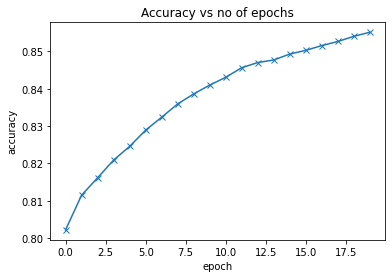

In [ ]:
#Ploting the accuracies
history = history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs no of epochs')

Text(0.5, 1.0, 'Loss  vs no of epochs')

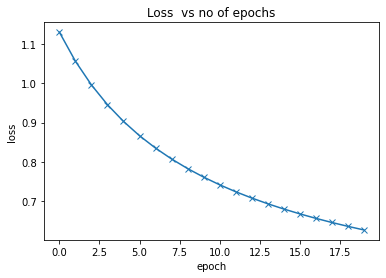

In [ ]:
#Ploting the losses
history = history1 + history2 + history3 + history4
accuracies = [result['val_loss'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss  vs no of epochs')

#Testinng the model

In [ ]:
#Define the test dataset
test_dataset = MNIST(root='data/', 
                      train=False, 
                      transform=transforms.ToTensor())

Shape:  torch.Size([1, 28, 28])
Label:  7


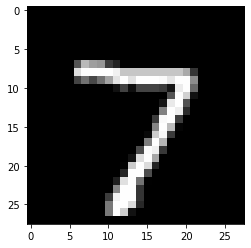

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape: ', img.shape)
print('Label: ', label)

In [ ]:
#Function for predicting the model
def predict_image(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds

label:  7 prediction:  tensor([7])


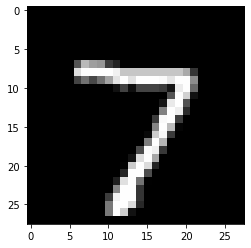

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('label: ', label, 'prediction: ', predict_image(img, model))

In [ ]:
#Calculate the accuracy on test dataset
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.86865234375, 'val_loss': 0.5885125398635864}

In [ ]:
#Saving the model
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [ ]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0090,  0.0001,  0.0143,  ...,  0.0234, -0.0182,  0.0118],
                      [ 0.0159, -0.0021, -0.0075,  ..., -0.0069, -0.0038,  0.0057],
                      [ 0.0005, -0.0215,  0.0326,  ..., -0.0230,  0.0168, -0.0296],
                      ...,
                      [-0.0082,  0.0293, -0.0272,  ...,  0.0197,  0.0065, -0.0108],
                      [-0.0068,  0.0355,  0.0220,  ..., -0.0105, -0.0015,  0.0188],
                      [ 0.0199,  0.0334,  0.0040,  ..., -0.0313, -0.0077, -0.0159]])),
             ('linear.bias',
              tensor([-0.0730,  0.0825, -0.0063, -0.0127, -0.0025,  0.0305,  0.0109,  0.0351,
                      -0.1233, -0.0088]))])

In [ ]:
model2 = MinistModel()

In [ ]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0264,  0.0225, -0.0097,  ..., -0.0199,  0.0324, -0.0311],
                      [ 0.0225,  0.0089, -0.0191,  ...,  0.0213, -0.0222, -0.0273],
                      [ 0.0201, -0.0279,  0.0172,  ..., -0.0169,  0.0142,  0.0142],
                      ...,
                      [ 0.0337, -0.0124, -0.0264,  ...,  0.0264,  0.0016,  0.0052],
                      [ 0.0158, -0.0112,  0.0324,  ..., -0.0015,  0.0237,  0.0010],
                      [ 0.0188,  0.0104,  0.0351,  ...,  0.0335,  0.0227, -0.0309]])),
             ('linear.bias',
              tensor([-0.0213, -0.0353, -0.0020,  0.0119,  0.0062,  0.0252, -0.0176, -0.0202,
                       0.0068, -0.0186]))])

In [ ]:
evaluate(model2, test_loader)

{'val_acc': 0.11865234375, 'val_loss': 2.3235044479370117}

In [ ]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0090,  0.0001,  0.0143,  ...,  0.0234, -0.0182,  0.0118],
                      [ 0.0159, -0.0021, -0.0075,  ..., -0.0069, -0.0038,  0.0057],
                      [ 0.0005, -0.0215,  0.0326,  ..., -0.0230,  0.0168, -0.0296],
                      ...,
                      [-0.0082,  0.0293, -0.0272,  ...,  0.0197,  0.0065, -0.0108],
                      [-0.0068,  0.0355,  0.0220,  ..., -0.0105, -0.0015,  0.0188],
                      [ 0.0199,  0.0334,  0.0040,  ..., -0.0313, -0.0077, -0.0159]])),
             ('linear.bias',
              tensor([-0.0730,  0.0825, -0.0063, -0.0127, -0.0025,  0.0305,  0.0109,  0.0351,
                      -0.1233, -0.0088]))])

In [ ]:
evaluate(model2, test_loader)

{'val_acc': 0.86865234375, 'val_loss': 0.5885125398635864}